# Paired integration (CITE-seq)

In this notebook we showcase basic Multigrate functionality and integrate a CITE-seq dataset to obtain a joint gene expression and protein abundance representation in a latent space. We use publically available dataset from NeurIPS 2021 workshop https://openproblems.bio/neurips_2021/. We use the preprocessed data (see preprocessing notebooks).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import multigrate as mtg

Global seed set to 0
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [3]:
rna = sc.read('data/cite/rna_cite_hvg.h5ad')
rna

AnnData object with n_obs × n_vars = 90261 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [4]:
adt = sc.read('data/cite/adt.h5ad')
adt

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'clr', 'counts'

## Prep the input AnnData object

First, we need to organize anndatas correspoding to different datasets and modalities into 1 anndata object. In this example we have 1 CITE-seq dataset, hence we input 2 anndata objects: 1 for RNA modality and 1 for ADT modality.

Notes:
- paired datasets have to have the same .obs_names, i.e. index
- each sublist in `adatas`, `layers` parameters corresponds to one modality. If you have multiple objects per modality, append them to the corresponding list;
- objects in each sublist *have* to have the same set of features: if you want to integrate multiple RNA objects, we recommend first concatenating full objects and then subsetting to 2000-4000 highly variable genes; for ADT modality, we take the intersection of available proteins (double check the naming conventions, as that can vary a lot from one dataset to another, so `.var_names` can have almost no intersection but if you align the protein names, then there is an overlap);
- `layers` parameter specifies which layer the model should take the counts from. If `None`, then defaults to `.X`. The distribution of the input data should be the same within a modality, e.g. here we use raw counts for RNA-seq modality.

In [5]:
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [adt]],            # a list of anndata objects per modality, RNA-seq always goes first
    layers = [['counts'], ['clr']],     # if need to use data from .layers, if None use .X
)
adata

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 90261 × 4134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group'
    var: 'modality'
    uns: 'modality_lengths'
    layers: 'counts'

From now on, we work with one concatenated anndata object ```adata```.

If using raw counts for scRNA, we need to use NB loss (or ZINB), thus need to calculate `size_factors` first. If using normalized counts and MSE for scRNA, `rna_indices_end` does not need to be specified. Here we also want to correct for batch effects, so we specify  `batch` as a categorical covariate.

In [6]:
mtg.model.MultiVAE.setup_anndata(
    adata, 
    categorical_covariate_keys=["batch"],
    rna_indices_end = 4000,
)

## Initialize the model

Define the model here. If using raw counts for RNA-seq, use NB loss, if normalized counts, use MSE. For ADT we use CLR-normalized counts and MSE loss.

In [7]:
model = mtg.model.MultiVAE(
    adata, 
    losses=['nb', 'mse'],
)

## Train the model

One can specify the number of epochs by setting `max_epochs` parameter, default is 256. The default batch size is set to `batch_size = 256`, adjust if needed.

In [8]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [23:12<00:00,  6.56s/it, loss=1.08e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [23:12<00:00,  6.96s/it, loss=1.08e+03, v_num=1]


Let's plot losses.

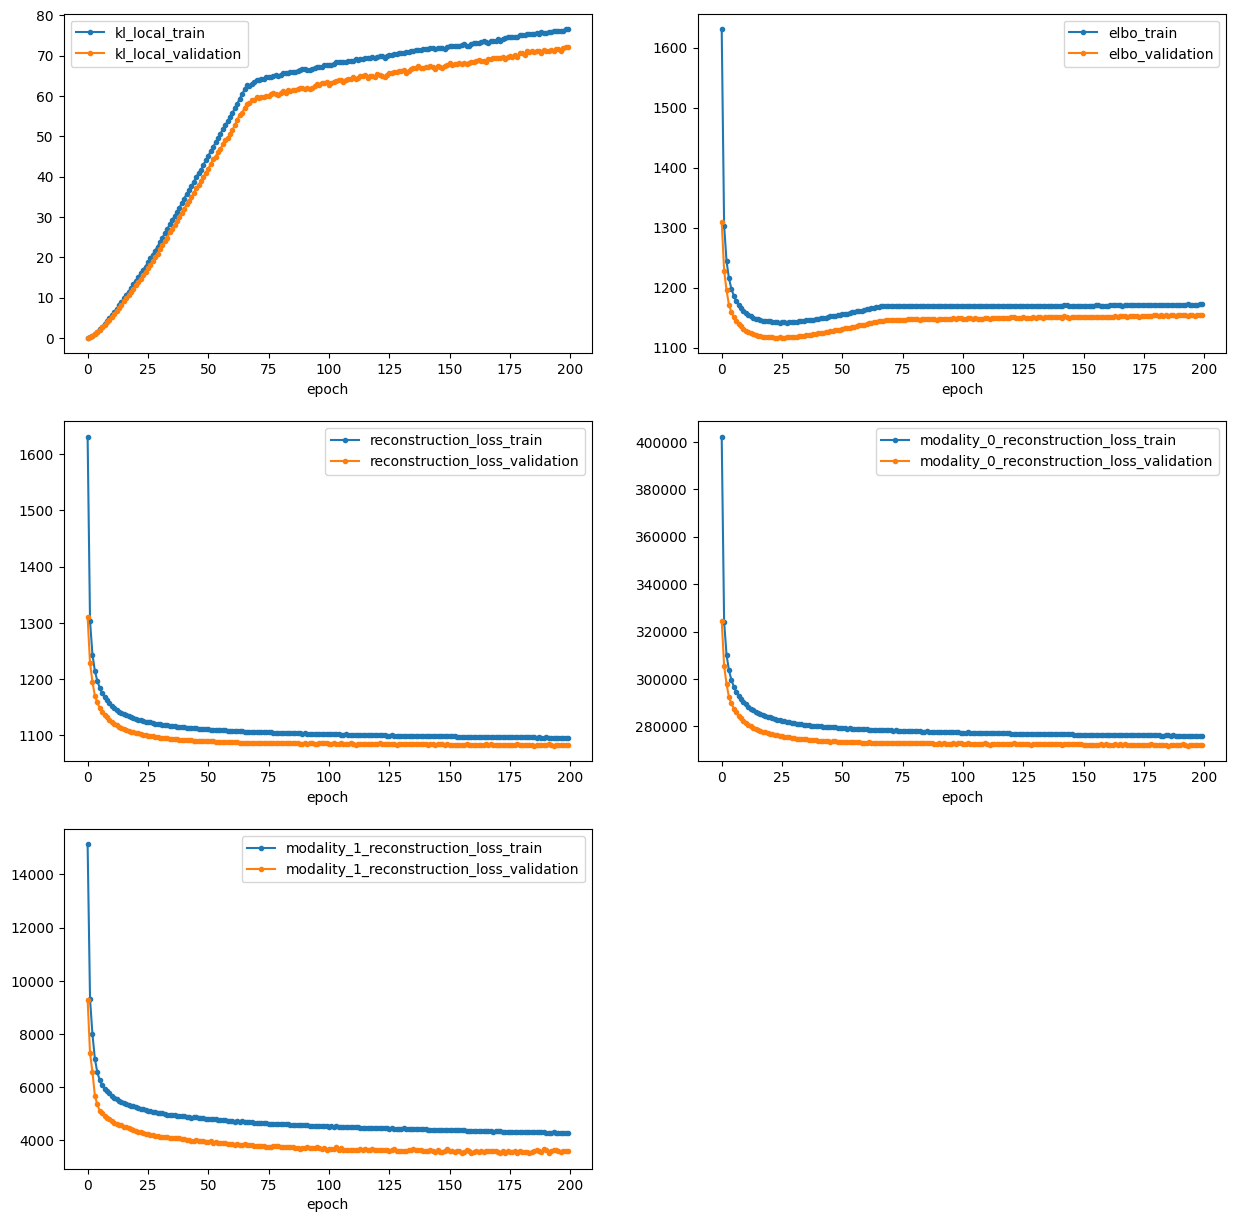

In [9]:
model.plot_losses()

## Inference

Get the latent representation.

In [10]:
model.get_latent_representation()
adata

AnnData object with n_obs × n_vars = 90261 × 4134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'group', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: 'modality_lengths', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', 'latent'
    layers: 'counts'

Visualize results.

In [11]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


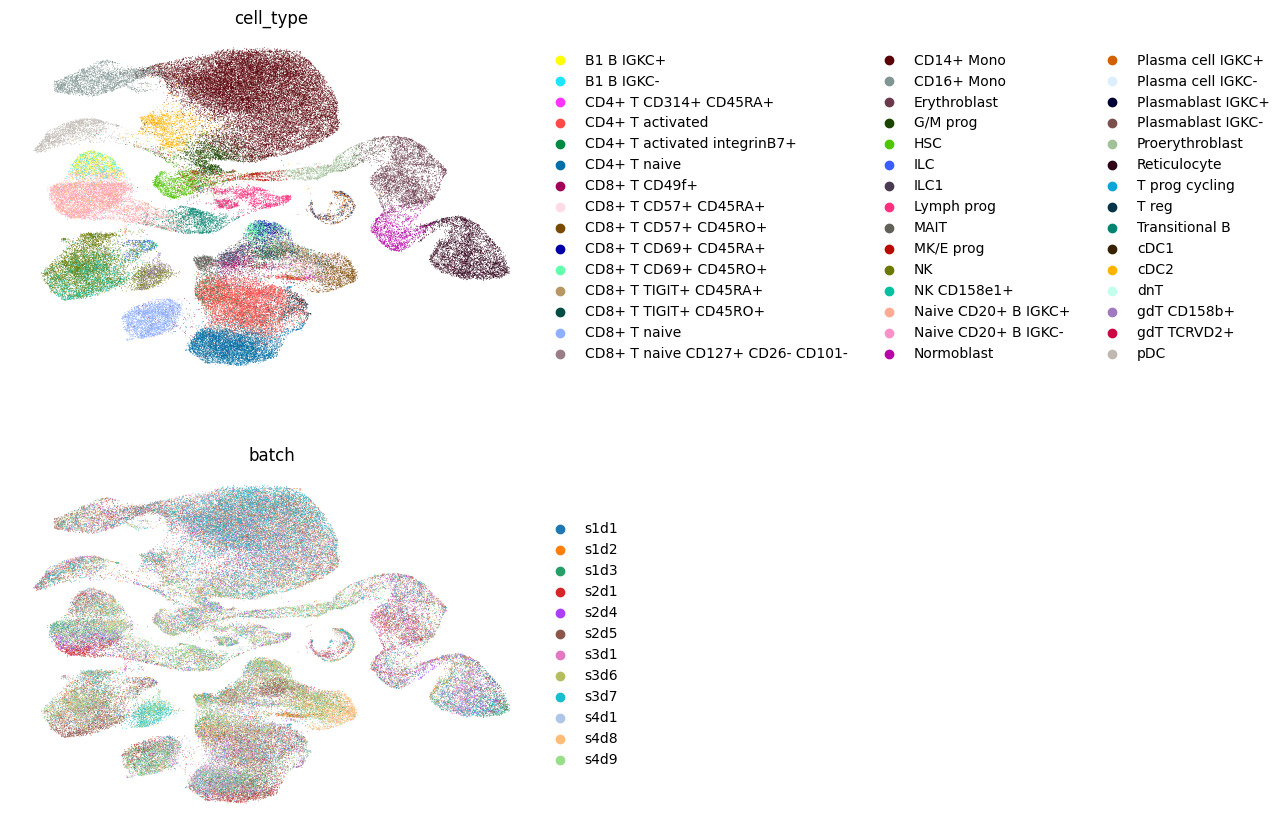

In [12]:
sc.pl.umap(adata, color=['cell_type', 'batch'], frameon=False, ncols=1)